In [0]:
import torch
import torchtext

# The first time you run this will download a ~823MB file
glove = torchtext.vocab.GloVe(name="twitter.27B", # trained on Twitter 2014 corpus
                              dim=200)   # embedding size = 50

In [0]:
#setup Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

# file location (make sure to use your file location)
#file_dir_sam = '/content/drive/My Drive/Colab Notebooks/aps360/Lectures/'
file_dir = '/content/drive/My Drive/Colab Notebooks/aps360/Projects/'

def get_data():
    return csv.reader(open(file_dir + "parsed_data.csv"))

def split_tweet(tweet,print_data):
    # separate punctuations
    
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")   

    if(print_data < 2):
      print("Original Data: ")
      print(tweet)
      print("Split and Normalized Data: ")
      print(tweet.lower().split())
    return tweet.lower().split()

In [0]:
import pandas as pd

columns = ['label', 'text']
#columns = ['text']
df_train = pd.DataFrame(columns=columns)
df_val = pd.DataFrame(columns=columns)
df_test = pd.DataFrame(columns=columns)

In [0]:
def get_tweet_words(glove_vector):
    print_data = 0
    train, valid, test = [], [], []
    tr,vl,te = 0,0,0
    num_pos, num_neg = 0, 0
    pos_train,neg_train, pos_val,neg_val, pos_test,neg_test = 0,0,0,0,0,0
    for i, line in enumerate(get_data()):
        if i % 1 == 0:
            tweet = line[-1]
            #print(tweet)
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet,print_data)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            
            if (print_data < 2):
              print("Glove indexed data: ")
              print(idxs)

            idxs = torch.tensor(idxs) # convert list to pytorch tensor 

            if (print_data < 2):
              print("Tensor data: ")
              print(idxs)

            print_data +=1 

            # label = torch.tensor(int(line[0] == "4")).long()
            #label = torch.tensor(int(line[0] == "0")).long()
            if (line[0] == '0'):
              label = torch.tensor(int(1)).long()
            else:
              label = torch.tensor(int(0)).long() 

            label_panda = 'sdf'
            if (label.item() == 0):
                label_panda = 'neg'
                num_neg +=1
            elif(label.item() == 1):
                label_panda = 'pos'
                num_pos +=1

            if i % 5 < 3:
                s1 = [tweet, label.item()]
                df_train.loc[tr, 'text'] = tweet
                df_train.loc[tr, 'label'] = label_panda #label.item()
                tr+=1
                train.append((idxs, label))

                if(label == 1):
                  pos_train +=1

                elif(label == 0): 
                  neg_train +=1

            elif i % 5 == 4:
                s1 = [tweet, label.item()]
                df_val.loc[vl, 'text'] = tweet
                df_val.loc[vl, 'label'] = label_panda           
                vl+=1          
                valid.append((idxs, label))

                if(label == 1):
                  pos_val +=1

                elif(label == 0): 
                  neg_val +=1                
            else:
                s1 = [tweet, label.item()]
                df_test.loc[te, 'text'] = tweet
                df_test.loc[te, 'label'] = label_panda
                te+=1           
                test.append((idxs, label))
                if(label == 1):
                  pos_test +=1

                elif(label == 0): 
                  neg_test +=1

    print("num pos = " + str(num_pos))    
    print("num neg = " + str(num_neg))  

    print("num pos train = " + str(pos_train))    
    print("num neg  train = " + str(neg_train))    

    print("num pos val = " + str(pos_val))    
    print("num neg  val = " + str(neg_val))    

    print("num pos test = " + str(pos_test))    
    print("num neg  test = " + str(neg_test))    

    return train, valid, test

train, valid, test = get_tweet_words(glove)


Original Data: 
Who is the biggest gossiper you know ? 
Split and Normalized Data: 
['who', 'is', 'the', 'biggest', 'gossiper', 'you', 'know', '?']
Glove indexed data: 
[127, 32, 13, 1971, 519588, 15, 115, 14]
Tensor data: 
tensor([   127,     32,     13,   1971, 519588,     15,    115,     14])
Original Data: 
Get fucking real dude . 
Split and Normalized Data: 
['get', 'fucking', 'real', 'dude', '.']
Glove indexed data: 
[87, 408, 312, 1052, 1]
Tensor data: 
tensor([  87,  408,  312, 1052,    1])
num pos = 12022
num neg = 7800
num pos train = 7211
num neg  train = 4681
num pos val = 2404
num neg  val = 1559
num pos test = 2407
num neg  test = 1560


In [0]:
print(len(train))
print(len(valid))
print(len(test))

11892
3963
3967


In [0]:
print(train[0])

(tensor([   127,     32,     13,   1971, 519588,     15,    115,     14]), tensor(0))


In [0]:
df_train[:3]

,label,text
0,neg,Who is the biggest gossiper you know?
1,neg,that sucks... she should prolly just change he...
2,neg,dig deep and find that special Christmas hate!


In [0]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)#nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, (h0,c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [0]:
class TweetRNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN_GRU, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)#nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [0]:
from torch.nn.utils.rnn import pad_sequence

tweet_padded = pad_sequence([tweet for tweet, label in train[:10]],
                            batch_first=True)
print(tweet_padded.shape)

torch.Size([10, 26])


In [0]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [0]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [0]:
def get_loss(model, data_loader, criterion):
    total_loss = 0.0

    for i, batch in enumerate(data_loader):
    # for tweets, labels in data_loader:
        tweets = batch[0]
        labels = batch[1]
        output = model(tweets)
        loss = criterion(output, labels)
        total_loss += loss.item()      
            
    loss = float(total_loss)/ (i + 1)
    return loss

In [0]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)
    losses, train_acc, valid_acc, val_loss = [], [], [],[]
    epochs = []
    for epoch in range(num_epochs):
        i = 0
        for tweets, labels in train:
            optimizer.zero_grad()
    
            pred = model(tweets)

            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            i+=1


        losses.append(float(loss))#/(i+1))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        val_loss.append(get_loss(model, valid_loader, criterion))
        print("Epoch %d; Train Loss %f; Train Acc %f; Val Loss %f; Val Acc %f" % (
              epoch+1, losses[-1], train_acc[-1], val_loss[-1], valid_acc[-1]))
        

    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.plot(epochs, val_loss, label="Validation")    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Train Loss 0.487989; Train Acc 0.701165; Val Loss 0.548734; Val Acc 0.689629
Epoch 2; Train Loss 0.484567; Train Acc 0.746990; Val Loss 0.542859; Val Acc 0.720161
Epoch 3; Train Loss 0.368674; Train Acc 0.777864; Val Loss 0.517169; Val Acc 0.733535
Epoch 4; Train Loss 0.284601; Train Acc 0.810583; Val Loss 0.471717; Val Acc 0.736311
Epoch 5; Train Loss 0.377751; Train Acc 0.885243; Val Loss 0.413765; Val Acc 0.789301
Epoch 6; Train Loss 0.230525; Train Acc 0.929126; Val Loss 0.396685; Val Acc 0.821600
Epoch 7; Train Loss 0.114571; Train Acc 0.960097; Val Loss 0.380983; Val Acc 0.844815


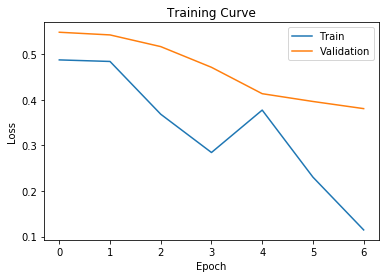

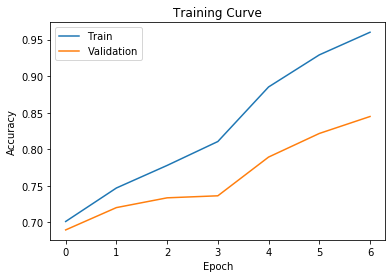

In [98]:
model = TweetRNN_GRU(200, 100, 2)#lstm
train_loader = TweetBatcher(train, batch_size=100, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=100, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=7, learning_rate=0.003)

In [0]:
def get_new_tweet(glove_vector, sample_tweet):
    tweet = sample_tweet
    idxs = [glove_vector.stoi[w]        # lookup the index of word
            for w in split_tweet(tweet,3)
            if w in glove_vector.stoi] # keep words that has an embedding
    idxs = torch.tensor(idxs) # convert list to pytorch tensor
    return idxs

In [0]:
new_tweet = get_new_tweet(glove, "you'r fat")
#print(new_tweet.shape)

out = torch.sigmoid(model(new_tweet.unsqueeze(0)))
pred = out.max(1, keepdim=True)[1]
print(pred)

tensor([[0]])


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(df_train['text'])
test_vectors = vectorizer.transform(df_test['text'])

In [102]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
print(df_train['label'])
classifier_linear.fit(train_vectors, df_train['label'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(df_test['label'], prediction_linear, output_dict=True)
print('positive: ', report['pos'])
print('negative: ', report['neg'])

0        pos
1        neg
2        neg
3        neg
4        neg
        ... 
11887    pos
11888    pos
11889    pos
11890    pos
11891    pos
Name: label, Length: 11892, dtype: object
Training time: 17.817012s; Prediction time: 4.311406s
positive:  {'precision': 0.854416333777186, 'recall': 0.7997507270461155, 'f1-score': 0.8261802575107297, 'support': 2407}
negative:  {'precision': 0.7187864644107351, 'recall': 0.7897435897435897, 'f1-score': 0.752596212583995, 'support': 1560}


In [0]:
test_loader = TweetBatcher(test, batch_size=600, drop_last=False)

In [100]:
test_accuracy = get_accuracy(model, test_loader)
print(test_accuracy)

0.8578270733551803


In [0]:
if(pred_text == '0' && pred_img == 'angry'):
  print('Bullying')
elif (pred_text == '0' && pred_img == 'disgusted'):
  print('Bullying')
elif (pred_text == '0' && pred_img == 'neutral'):
  ###TO DO ARRAY
  #array of size blank
  #if len(array) == full drop the last one(first one inserted)
  #append(result of tensor into array)
else:
  print("pass!")
